E0000 00:00:1750865813.158754      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750865813.241044      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


=== Zeru Finance Credit Scoring System ===

[1/4] Loading data...

Processing files:
- /kaggle/input/eth-sample-dataset/compoundV2_transactions_ethereum_chunk_1.json
- /kaggle/input/eth-sample-dataset/compoundV2_transactions_ethereum_chunk_0.json
- /kaggle/input/eth-sample-dataset/compoundV2_transactions_ethereum_chunk_2.json

Loaded 135,139 transactions from 17,231 unique wallets

Time range of transactions: 2019-05-07 01:41:22 to 2025-03-13 20:13:47
Dataset covers 2137 days

[2/4] Creating behavioral features...

Generated 31 features per wallet, including temporal features:
                       mean           std           min           max
time_entropy   8.402489e-01  7.928370e-01 -1.000000e-10  3.155131e+00
periodicity    4.229165e+07  5.308106e+09  0.000000e+00  6.960121e+11
time_skew      6.214066e-01  1.274189e+00 -1.388720e+00  2.394059e+01
time_kurtosis  1.301149e+00  1.262890e+01 -2.000000e+00  7.667804e+02
autocorr_1d    3.516510e-03  8.424422e-02 -7.740469e-01  7.808917e

I0000 00:00:1750865901.528500      13 service.cc:148] XLA service 0xb6f3a10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750865901.529452      13 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1750865903.710001      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Calculating risk categories...

[4/4] Analyzing transaction patterns...

=== Transaction Category Analysis ===
Total Wallet Transactions: 135,139
Total Unique Wallets: 17,231

Main Categories:
  Category  Wallet Occurrences  Unique Wallets Percentage of Total  Transaction Count Total Volume (USD) Avg Volume per Wallet
  deposits               28941            8182               47.5%              28941    $256,827,044.85            $31,389.27
 withdraws               28692            8340               48.4%              28692    $246,268,597.49            $29,528.61
   borrows               29275            4087               23.7%              29275    $292,481,212.08            $71,563.79
    repays               27499            2967               17.2%              27499    $251,981,604.12            $84,928.08
liquidates               20732            4936               28.6%              20732  $1,210,697,586.69           $245,279.09

Ad

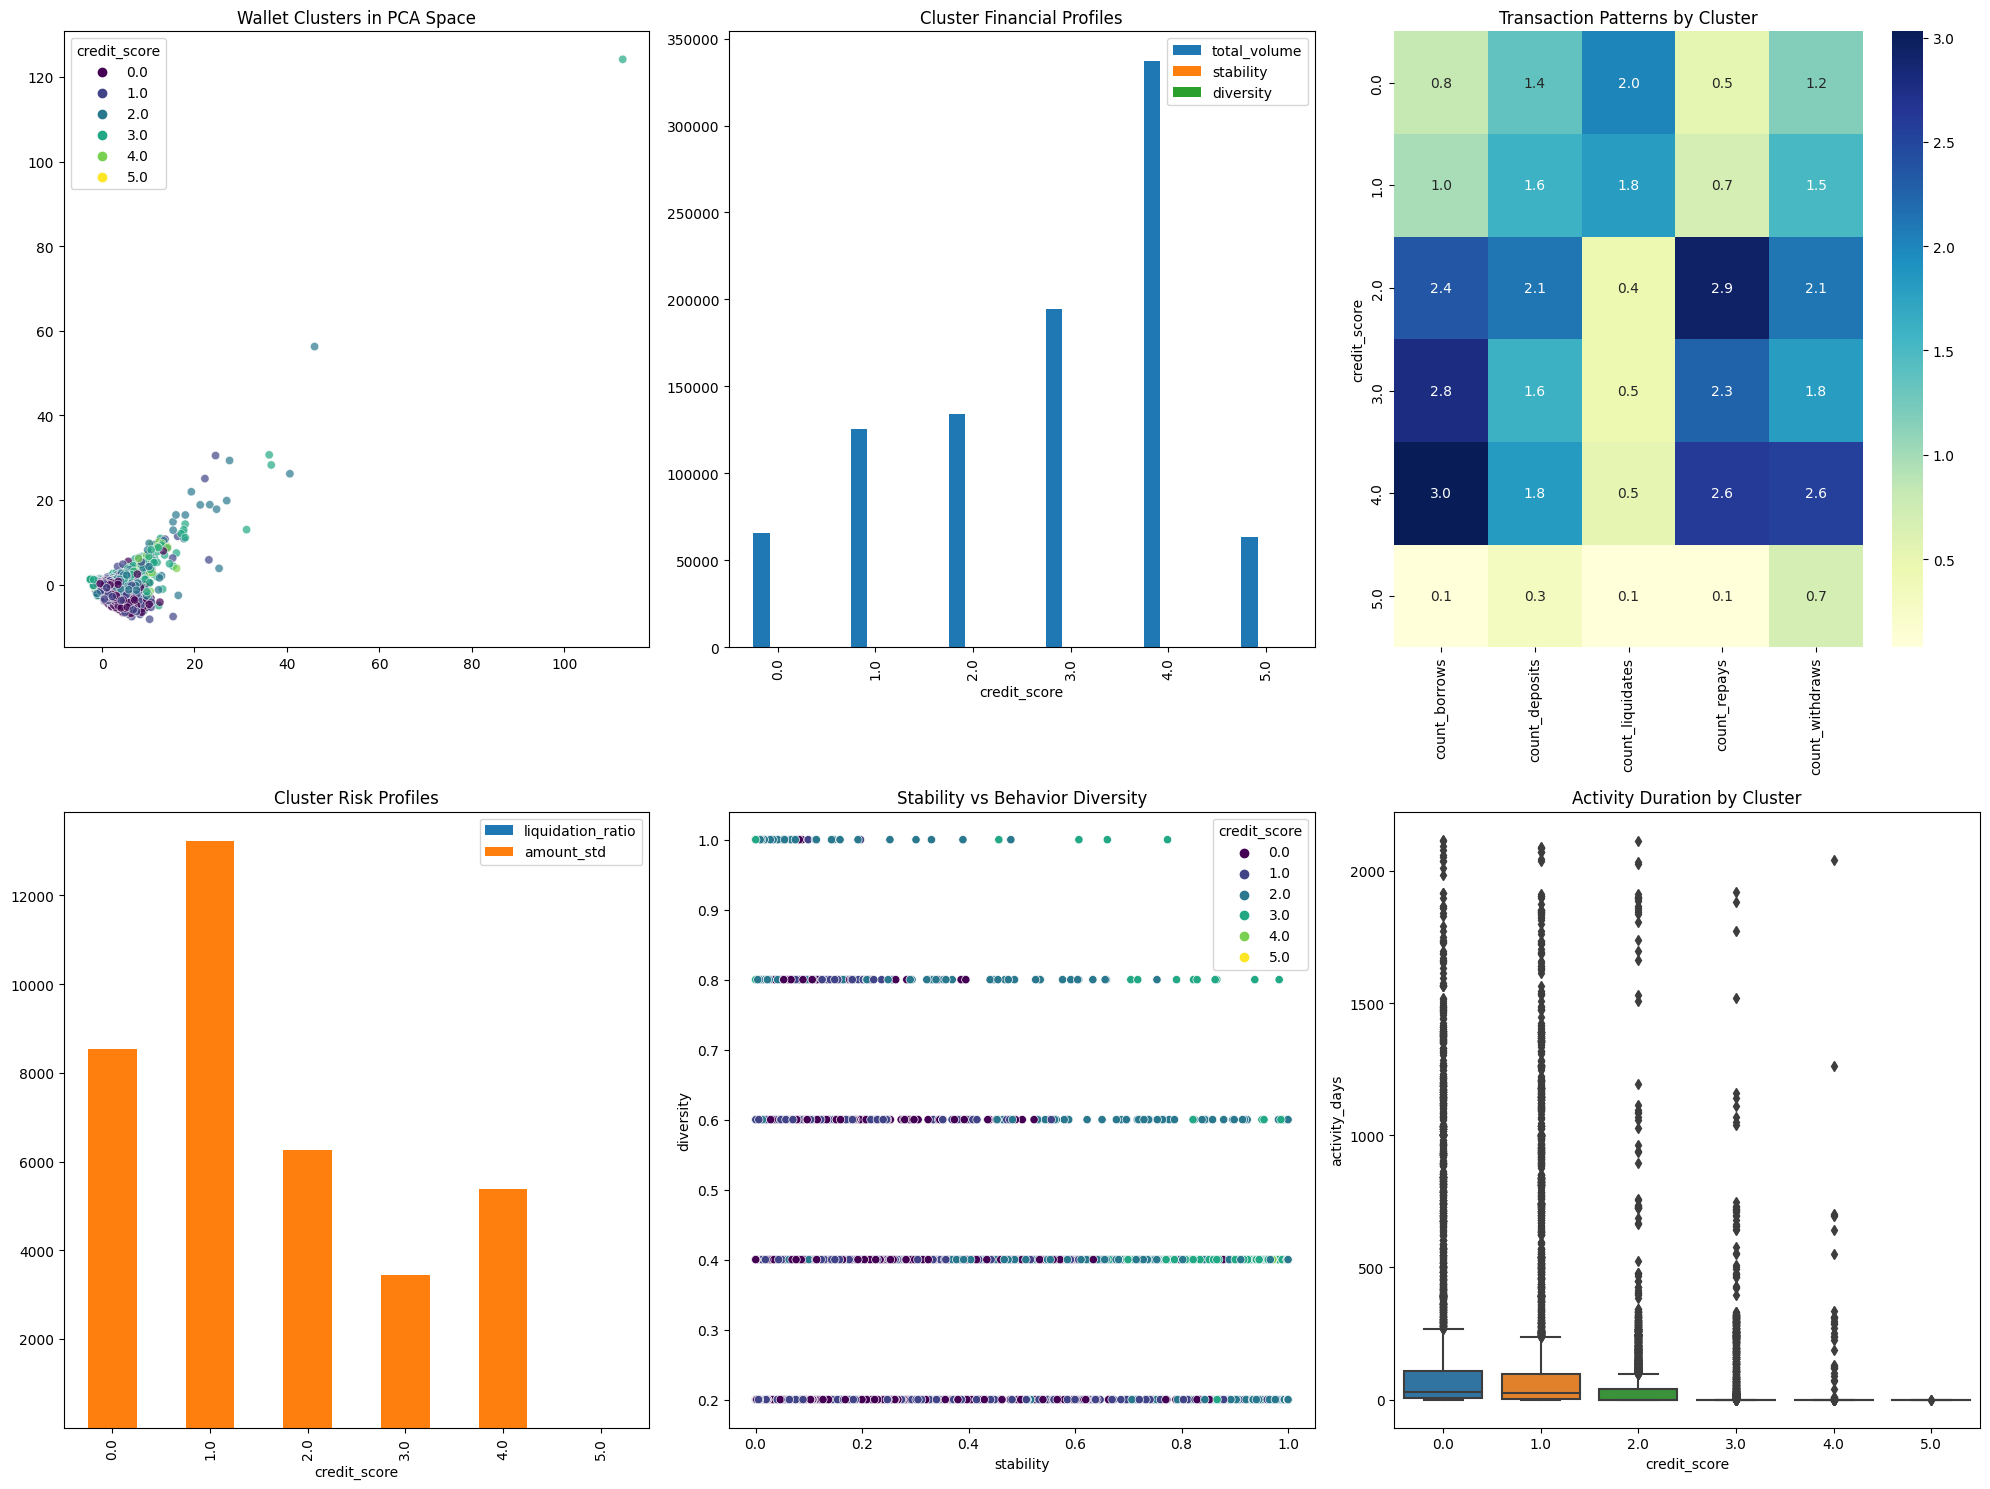

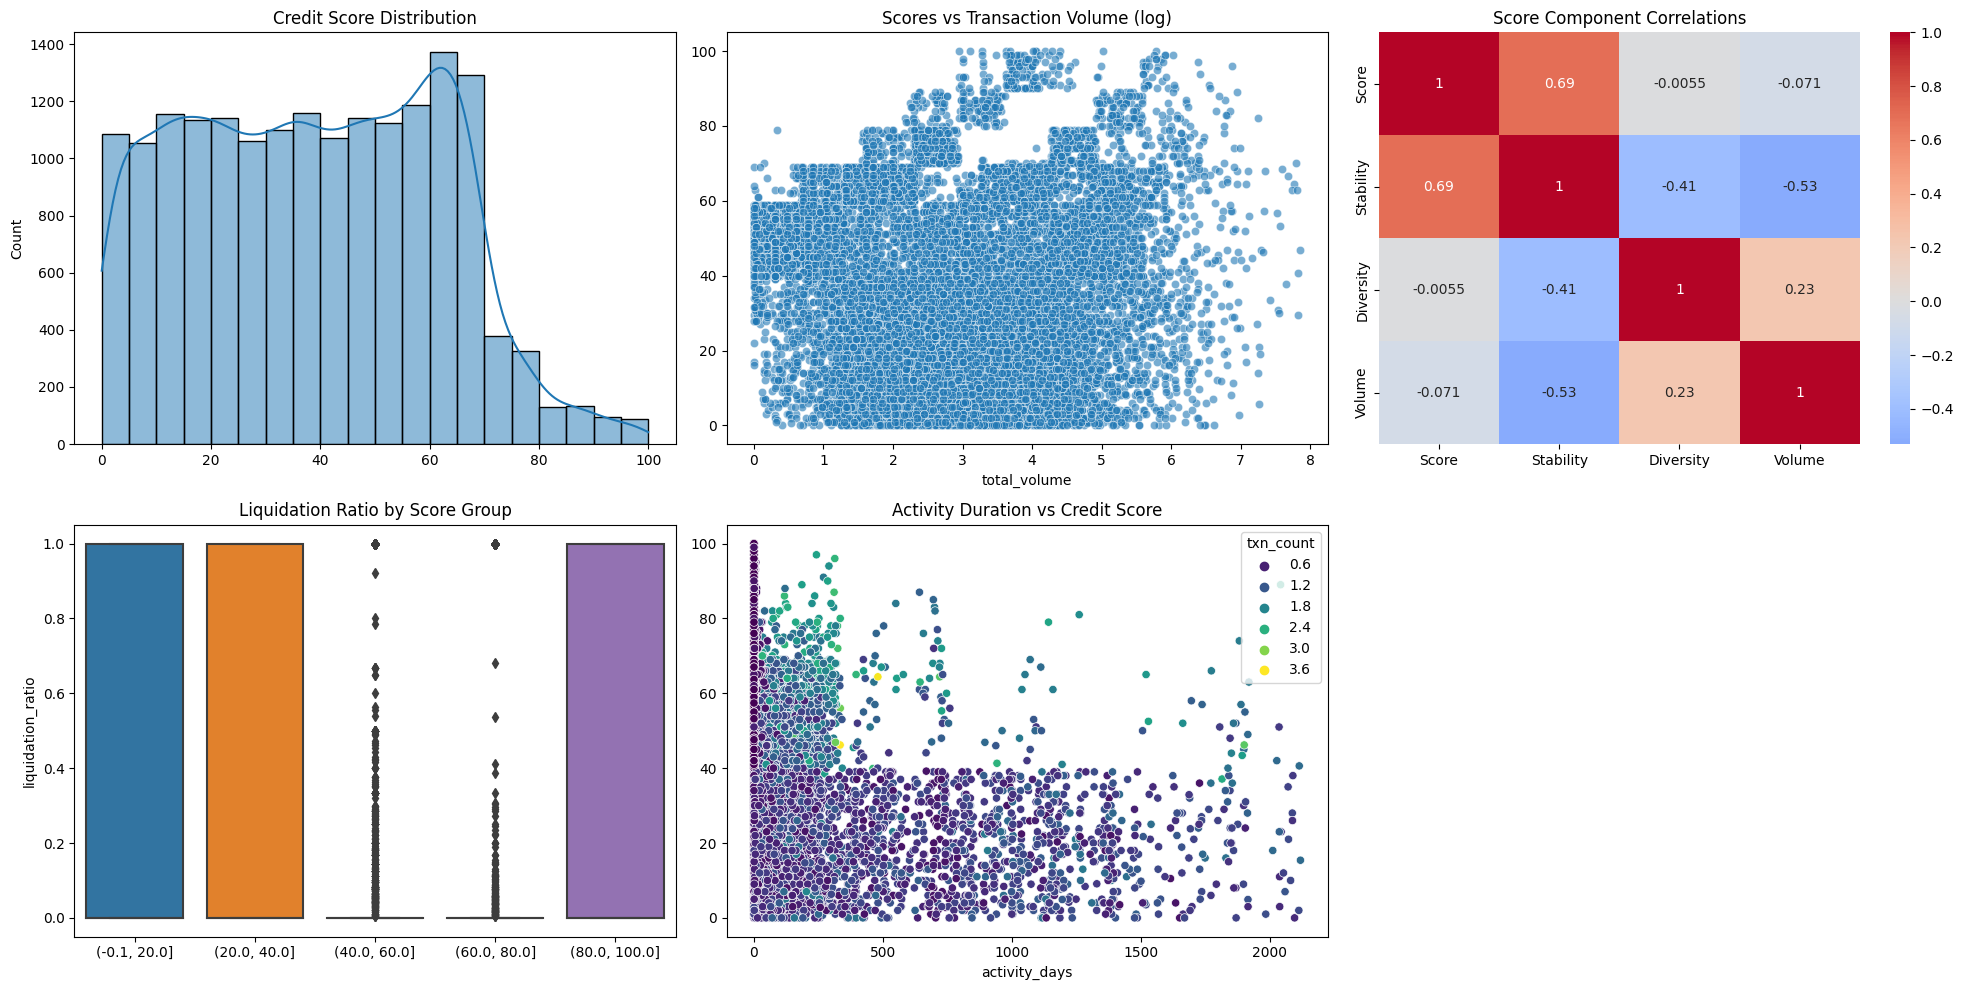


=== Grouped Wallet Scores with Status ===
Group    Score Range  Wallet Count    Percentage   Status                                                                                        
0        0-10         2,345           13.6%        Highly Risky Behaviour - Immediate Investigation Necessary: Bot-Like or Exploitative behaviour
1        11-25        3,406           19.8%        Highly Risky Behaviour - Immediate Investigation Necessary: Bot-Like or Exploitative behaviour
2        26-40        3,321           19.3%                      Risky Behaviour - Wallets need Investigation                                    
3        41-65        5,986           34.7%                      Risky Behaviour - Wallets need Investigation                                    
4        66-85        1,886           10.9%                      Mostly Safe Behaviour - Wallets Clear                                           
5        86-100       287             1.7%                       Mostly Safe Beha

In [1]:
import os
#This is for removing kaggle errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Don't use other value than GPU 0, code crashes on kaggle notebook

import warnings
warnings.filterwarnings("ignore")

import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.signal import periodogram
from statsmodels.tsa.stattools import acf

try:
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError as e:
            print(f"GPU config error: {e}")
except ImportError as e:
    print(f"TensorFlow import error: {e}")
    raise

#Data Loading 
def find_largest_json_files(directory, n=3): #You can change value of n to include more files
    try:
        files = []
        if not os.path.exists(directory):
            raise FileNotFoundError(f"Directory not found: {directory}")      
        for f in Path(directory).rglob('*.json'):
            try:
                size = os.path.getsize(f)
                files.append((str(f), size))
            except (OSError, PermissionError) as e:
                print(f"Skipping file {f}: {str(e)}")
                continue
        
        if not files:
            raise FileNotFoundError(f"No JSON files found in {directory}")
        
        files.sort(key=lambda x: -x[1])
        return [f[0] for f in files[:n]]
    except Exception as e:
        raise RuntimeError(f"Error finding files in {directory}: {str(e)}")

def parse_transaction_data(file_paths):
    records = []
    for file in file_paths:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                for tx_type, txs in data.items():
                    if not isinstance(txs, list):
                        txs = txs.get('transactions', [])
                    for tx in txs:
                        try:
                            wallet = tx.get('account', {}).get('id') or tx.get('liquidatee', {}).get('id')
                            if not wallet:
                                continue
                            
                            timestamp = tx.get('timestamp')
                            if isinstance(timestamp, str):
                                try:
                                    timestamp = int(timestamp)
                                except ValueError:
                                    timestamp = 0
                            elif not isinstance(timestamp, (int, float)):
                                timestamp = 0
                            
                            records.append({
                                'wallet': wallet.lower(),
                                'action': tx_type,
                                'amountUSD': float(tx.get('amountUSD', 0)),
                                'timestamp': timestamp,
                                'hash': tx.get('hash', '') 
                            })
                        except (AttributeError, ValueError, TypeError) as e:
                            print(f"Skipping malformed transaction in {file}: {str(e)}")
                            continue
        except (json.JSONDecodeError, IOError) as e:
            print(f"Skipping invalid file {file}: {str(e)}")
            continue
    
    if not records:
        raise ValueError("No valid transactions found in any files")
    
    df = pd.DataFrame(records).drop_duplicates(subset=['wallet', 'hash'], keep='first')
    
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    
    invalid_timestamps = df['datetime'].isna()
    if invalid_timestamps.any():
        print(f"Warning: {invalid_timestamps.sum()} transactions had invalid timestamps")
        median_timestamp = df.loc[~invalid_timestamps, 'datetime'].median()
        df.loc[invalid_timestamps, 'datetime'] = median_timestamp
    
    return df

# Feature Engineering
def calculate_temporal_features(wallet_transactions):
    default_values = {
        'time_entropy': 0,
        'periodicity': 0,
        'time_skew': 0,
        'time_kurtosis': 0,
        'autocorr_1d': 0,
        'autocorr_7d': 0,
        'active_hours': 0,
        'time_std': 0,
        'recency': 0
    }
    
    if len(wallet_transactions) < 1:
        return default_values
    
    try:
        times = wallet_transactions['datetime'].sort_values()
        
        last_activity = times.max()
        current_time = pd.Timestamp.now()
        recency_days = (current_time - last_activity).total_seconds() / 86400
        default_values['recency'] = recency_days
        
        if len(wallet_transactions) < 2:
            return default_values
            
        time_diffs = times.diff().dt.total_seconds().dropna()
        
        if len(time_diffs) > 0:
            default_values.update({
                'time_skew': skew(time_diffs),
                'time_kurtosis': kurtosis(time_diffs),
                'time_std': np.log1p(time_diffs.std())
            })
        
        try:
            if len(time_diffs) > 1:
                f, Pxx = periodogram(time_diffs, detrend='linear')
                default_values['periodicity'] = np.sum(Pxx[f < 1e-3])
        except:
            pass
        

        hours = times.dt.hour
        hour_counts = hours.value_counts(normalize=True)
        if len(hour_counts) > 0:
            default_values.update({
                'active_hours': len(hour_counts[hour_counts > 0.05]),
                'time_entropy': -np.sum(hour_counts * np.log(hour_counts + 1e-10))
            })
        
        try:
            if len(time_diffs) > 7:
                acf_vals = acf(time_diffs, nlags=7, fft=True)
                default_values.update({
                    'autocorr_1d': acf_vals[1],
                    'autocorr_7d': acf_vals[-1]
                })
        except:
            pass
            
        return default_values
        
    except Exception as e:
        print(f"Error calculating temporal features: {str(e)}")
        return default_values

def create_wallet_features(transactions):
    if transactions.empty:
        raise ValueError("Empty transaction dataframe provided")
    if 'wallet' not in transactions.columns:
        raise ValueError("Transactions dataframe missing 'wallet' column")
    try:
        action_counts = pd.pivot_table(
            transactions,
            index='wallet',
            columns='action',
            values='amountUSD',
            aggfunc='count',
            fill_value=0
        )
        action_counts.columns = [f"count_{col}" for col in action_counts.columns]
        
        financial = transactions.groupby('wallet').agg({
            'amountUSD': ['sum', 'mean', 'std', 'max', 'min', 'count', 
                         lambda x: np.median(np.abs(x - np.mean(x)))],
            'timestamp': [lambda x: (x.max() - x.min())/86400 if len(x) > 1 else 0]
        })
        financial.columns = [
            'total_volume', 'avg_amount', 'amount_std',
            'max_amount', 'min_amount', 'txn_count', 'amount_mad', 'activity_days'
        ]
        
        risk_metrics = transactions.groupby('wallet').apply(
            lambda x: pd.Series({
                'liquidation_ratio': x[x['action'] == 'liquidates'].shape[0] / x.shape[0] if x.shape[0] > 0 else 0,
                'large_tx_ratio': x[x['amountUSD'] > 10 * x['amountUSD'].mean()].shape[0] / x.shape[0] if x.shape[0] > 0 else 0,
                'volatility': x['amountUSD'].std() / (x['amountUSD'].mean() + 1e-10)
            })
        ).fillna(0)

        temporal_features = transactions.groupby('wallet').apply(
            lambda x: pd.Series(calculate_temporal_features(x)))
        
        required_temporal_cols = [
            'time_entropy', 'periodicity', 'time_skew', 'time_kurtosis',
            'autocorr_1d', 'autocorr_7d', 'active_hours', 'time_std', 'recency'
        ]
        for col in required_temporal_cols:
            if col not in temporal_features.columns:
                temporal_features[col] = 0
        
        all_indices = [
            action_counts.index,
            financial.index,
            risk_metrics.index,
            temporal_features.index
        ]
        common_index = all_indices[0]
        for idx in all_indices[1:]:
            common_index = common_index.intersection(idx)
        
        action_counts = action_counts.reindex(common_index, fill_value=0)
        financial = financial.reindex(common_index, fill_value=0)
        risk_metrics = risk_metrics.reindex(common_index, fill_value=0)
        temporal_features = temporal_features.reindex(common_index, fill_value=0)
        
        features = pd.concat([
            action_counts, 
            financial, 
            risk_metrics, 
            temporal_features
        ], axis=1).fillna(0)

        features['stability'] = 1 / (1 + features['amount_std'])
        features['diversity'] = (action_counts > 0).sum(axis=1) / len(action_counts.columns)
        features['time_variability'] = features[['time_skew', 'time_kurtosis', 'time_std']].mean(axis=1)
        features['behavior_consistency'] = features[['autocorr_1d', 'autocorr_7d']].mean(axis=1)
        features['recency_score'] = np.exp(-features['recency'] / 30) 
        
        features['risk_profile'] = (
            0.4 * features['liquidation_ratio'] + 
            0.3 * features['volatility'] + 
            0.2 * features['large_tx_ratio'] + 
            0.1 * (1 - features['behavior_consistency'])
        )
        
        features.replace([np.inf, -np.inf], 0, inplace=True)
        
        return features
        
    except Exception as e:
        print(f"Error in feature engineering: {str(e)}")
        raise
        
def compute_credit_scores(features):
    if len(features) == 0:
        raise ValueError("Empty features DataFrame")
    
    try:
        scaler = StandardScaler()
        X = scaler.fit_transform(features)
        
         # Neural Networks Clustering
        def create_autoencoder(input_dim, encoding_dim=32):
            input_layer = Input(shape=(input_dim,))
            encoder = Dense(encoding_dim, activation='relu')(input_layer)
            decoder = Dense(input_dim, activation='linear')(encoder)
            autoencoder = Model(inputs=input_layer, outputs=decoder)
            encoder_model = Model(inputs=input_layer, outputs=encoder)
            return autoencoder, encoder_model

        # Training of autoencoder
        autoencoder, encoder = create_autoencoder(X.shape[1])
        autoencoder.compile(optimizer=Adam(0.001), loss='mse')
        autoencoder.fit(X, X, epochs=100, batch_size=256, verbose=0)
        
        encoded = encoder.predict(X)
        
        kmeans = KMeans(n_clusters=10, random_state=42)
        clusters = kmeans.fit_predict(encoded)
        
        lof = LocalOutlierFactor(
            n_neighbors=min(20, len(X)-1),
            contamination=0.1,
            novelty=False
        )
        anomalies = lof.fit_predict(X)
        
        stability = features['stability'].values
        diversity = features['diversity'].values
        volume = np.log1p(features['total_volume'].values)
        risk = features['liquidation_ratio'].values
        
        behavior_score = (
            0.4 * (volume / np.max(volume)) +
            0.3 * stability +
            0.2 * diversity +
            0.1 * (1 - risk)
        )
        
        percentiles = np.percentile(behavior_score, [0, 50, 75, 90, 95, 98, 100])
        scores = np.zeros_like(behavior_score)
        
        masks = [
            behavior_score >= percentiles[5],
            (behavior_score >= percentiles[4]) & (behavior_score < percentiles[5]),
            (behavior_score >= percentiles[3]) & (behavior_score < percentiles[4]),
            (behavior_score >= percentiles[2]) & (behavior_score < percentiles[3]),
            (behavior_score >= percentiles[1]) & (behavior_score < percentiles[2]),
            behavior_score < percentiles[1]
        ]
        
        ranges = [
            (90, 101), (80, 90), (70, 80), (60, 70), (40, 60), (0, 40)
        ]
        
        for mask, (low, high) in zip(masks, ranges):
            scores[mask] = np.random.randint(low, high, size=np.sum(mask))
        
        scores = np.where(anomalies == -1, scores * 0.7, scores)
        scores = np.clip(scores, 0, 100)
        
        pca = PCA(n_components=2)
        components = pca.fit_transform(X)
        
        cluster_stats = pd.DataFrame({
            'cluster': clusters,
            'score': scores,
            'volume': features['total_volume'].values,
            'stability': features['stability'].values
        }).groupby('cluster').agg({
            'score': ['mean', 'std'],
            'volume': 'mean',
            'stability': 'mean',
            'cluster': 'count'
        })
        cluster_stats.columns = ['mean_score', 'score_std', 'mean_volume', 'mean_stability', 'wallet_count']
        
        score_distribution = pd.Series(scores).value_counts().to_dict()
        
        scores = pd.Series(scores, index=features.index)
        clusters = pd.Series(clusters, index=features.index)
        
        return scores, cluster_stats, components, score_distribution
        
    except Exception as e:
        raise RuntimeError(f"Scoring failed: {str(e)}")
        

# Data Visualization Functions are over here to make clustering and other graphs used in main()
def plot_cluster_analysis(features, clusters, components):
    plt.figure(figsize=(20, 15))
    
    # PCA Plot
    plt.subplot(231)
    sns.scatterplot(
        x=components[:, 0],
        y=components[:, 1],
        hue=clusters,
        palette='viridis',
        alpha=0.7
    )
    plt.title('Wallet Clusters in PCA Space')
    
    # Financial Profile
    plt.subplot(232)
    cluster_means = features.groupby(clusters)[['total_volume', 'stability', 'diversity']].mean()
    cluster_means.plot(kind='bar', ax=plt.gca())
    plt.title('Cluster Financial Profiles')
    
    # Transaction Patterns
    plt.subplot(233)
    action_cols = [c for c in features.columns if c.startswith('count_')]
    sns.heatmap(
        features[action_cols].groupby(clusters).mean(),
        annot=True,
        fmt='.1f',
        cmap='YlGnBu'
    )
    plt.title('Transaction Patterns by Cluster')
    
    # Risk Analysis
    plt.subplot(234)
    risk_features = features[['liquidation_ratio', 'amount_std']].groupby(clusters).mean()
    risk_features.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Cluster Risk Profiles')
    
    # Stability vs Diversity
    plt.subplot(235)
    sns.scatterplot(
        x=features['stability'],
        y=features['diversity'],
        hue=clusters,
        palette='viridis'
    )
    plt.title('Stability vs Behavior Diversity')
    
    # Activity Duration
    plt.subplot(236)
    sns.boxplot(
        x=clusters,
        y=features['activity_days']
    )
    plt.title('Activity Duration by Cluster')
    
    plt.tight_layout()
    plt.show()

def plot_score_analysis(scores, features):
    plt.figure(figsize=(20, 10))
    
    # Score Distribution
    plt.subplot(231)
    sns.histplot(scores, bins=20, kde=True)
    plt.title('Credit Score Distribution')
    
    # Score vs Volume
    plt.subplot(232)
    sns.scatterplot(
        x=np.log10(features['total_volume'] + 1),
        y=scores,
        alpha=0.6
    )
    plt.title('Scores vs Transaction Volume (log)')
    
    # Score Components
    plt.subplot(233)
    score_factors = pd.DataFrame({
        'Score': scores,
        'Stability': features['stability'],
        'Diversity': features['diversity'],
        'Volume': np.log10(features['total_volume'] + 1)
    })
    sns.heatmap(
        score_factors.corr(),
        annot=True,
        cmap='coolwarm',
        center=0
    )
    plt.title('Score Component Correlations')
    
    # Risk Indicators
    plt.subplot(234)
    sns.boxplot(
        x=pd.cut(scores, bins=5),
        y=features['liquidation_ratio']
    )
    plt.title('Liquidation Ratio by Score Group')
    
    # Temporal Patterns
    plt.subplot(235)
    sns.scatterplot(
        x=features['activity_days'],
        y=scores,
        hue=np.log10(features['txn_count'] + 1),
        palette='viridis'
    )
    plt.title('Activity Duration vs Credit Score')
    
    plt.tight_layout()
    plt.show()

def display_grouped_score_counts(scores):
    scores = np.array(scores)
    total_wallets = len(scores)
    
    group_bins = [-1, 10, 25, 40, 65, 85, 100]
    group_labels = [0, 1, 2, 3, 4, 5]
    range_labels = ["0-10", "11-25", "26-40", "41-65", "66-85", "86-100"]
    
    precise_bins = [0, 10.0000001, 25.0000001, 40.0000001, 65.0000001, 85.0000001, 100.0000001]
    
    indices = np.digitize(scores, precise_bins, right=False) - 1
    indices = np.clip(indices, 0, len(group_labels)-1)
    
    counts = np.bincount(indices, minlength=len(group_labels))
    
    group_df = pd.DataFrame({
        'Group': group_labels,
        'Score Range': range_labels,
        'Wallet Count': counts,
        'Percentage': (counts / total_wallets * 100).round(1)
    })
    
    outliers = scores[(scores < 0) | (scores > 100.0000001)]
    if len(outliers) > 0:
        print(f"Warning: {len(outliers)} outliers detected (min: {scores.min():.2f}, max: {scores.max():.2f})")
    
    print("\n=== Grouped Score Wallet Count ===")
    print(f"Total Wallets: {total_wallets:,}")
    print(group_df[['Group', 'Score Range', 'Wallet Count', 'Percentage']].to_string(
        index=False,
        formatters={
            'Wallet Count': '{:,.0f}'.format,
            'Percentage': '{:.1f}%'.format
        }
    ))
    
    return len(outliers)

def analyze_transaction_categories(transactions_df):
    categories = {
        'deposits': {'all_wallet_occurrences': 0, 'unique_wallets': set(), 'tx_counts': 0, 'total_volume': 0},
        'withdraws': {'all_wallet_occurrences': 0, 'unique_wallets': set(), 'tx_counts': 0, 'total_volume': 0},
        'borrows': {'all_wallet_occurrences': 0, 'unique_wallets': set(), 'tx_counts': 0, 'total_volume': 0},
        'repays': {'all_wallet_occurrences': 0, 'unique_wallets': set(), 'tx_counts': 0, 'total_volume': 0},
        'liquidates': {'all_wallet_occurrences': 0, 'unique_wallets': set(), 'tx_counts': 0, 'total_volume': 0}
    }
    
    all_wallets = set()
    total_wallet_occurrences = 0
    
    for _, row in transactions_df.iterrows():
        action = row['action']
        wallet = row['wallet']
        amount = row['amountUSD']
        
        all_wallets.add(wallet)
        total_wallet_occurrences += 1
        
        action_key = action
        if action.endswith('s') and action[:-1] in categories:
            action_key = action[:-1]
        elif action + 's' in categories:
            action_key = action + 's'
        
        if action_key in categories:
            categories[action_key]['all_wallet_occurrences'] += 1
            categories[action_key]['unique_wallets'].add(wallet)
            categories[action_key]['tx_counts'] += 1
            categories[action_key]['total_volume'] += amount
    
    categorized_wallets = set()
    for cat in categories.values():
        categorized_wallets.update(cat['unique_wallets'])
    potential_missing = all_wallets - categorized_wallets
    
    stats = []
    for cat_name, data in categories.items():
        stats.append({
            'Category': cat_name,
            'Wallet Occurrences': data['all_wallet_occurrences'],
            'Unique Wallets': len(data['unique_wallets']),
            'Percentage of Total': f"{(len(data['unique_wallets']) / len(all_wallets) * 100):.1f}%",
            'Transaction Count': data['tx_counts'],
            'Total Volume (USD)': f"${data['total_volume']:,.2f}",
            'Avg Volume per Wallet': f"${(data['total_volume'] / len(data['unique_wallets'])):,.2f}" if data['unique_wallets'] else "N/A"
        })
    
    return pd.DataFrame(stats), potential_missing, total_wallet_occurrences

def display_transaction_analysis(transactions_df):
    stats_df, missing_wallets, total_wallet_occurrences = analyze_transaction_categories(transactions_df)
    
    print("\n=== Transaction Category Analysis ===")
    print(f"Total Wallet Transactions: {total_wallet_occurrences:,}")
    print(f"Total Unique Wallets: {transactions_df['wallet'].nunique():,}")
    
    print("\nMain Categories:")
    print(stats_df[['Category', 'Wallet Occurrences', 'Unique Wallets', 'Percentage of Total', 
                    'Transaction Count', 'Total Volume (USD)', 'Avg Volume per Wallet']].to_string(index=False))
    
    if missing_wallets:
        print(f"\nWarning: {len(missing_wallets):,} wallets had uncategorized transactions")
        print("Sample of affected wallets:", list(missing_wallets)[:5])
    
    print("\nAdditional Statistics:")
    deposits_count = int(stats_df[stats_df['Category'] == 'deposits']['Unique Wallets'])
    liquidates_count = int(stats_df[stats_df['Category'] == 'liquidates']['Unique Wallets'])
    most_active = stats_df.loc[stats_df['Transaction Count'].idxmax()]['Category']
    
    print(f"- Wallets with only deposits: {deposits_count:,}")
    print(f"- Wallets involved in liquidations: {liquidates_count:,}")
    print(f"- Most active category: {most_active}")

# MAIN Function is over here

def main():
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
            except RuntimeError as e:
                print(f"GPU config error: {e}")
    except:
        print("GPU setting configuration failed.")

    try:
        print("=== Zeru Finance Credit Scoring System ===")
        
        print("\n[1/4] Loading data...")
        data_dir = '/kaggle/input/eth-sample-dataset'
        if not os.path.exists(data_dir):
            print(f"\nError: Data directory not found at {data_dir}")
            print("Available directories in /kaggle/input:")
            print(os.listdir('/kaggle/input'))
            return
            
        files = find_largest_json_files(data_dir)
        print(f"\nProcessing files:\n- " + "\n- ".join(files))
        
        transactions = parse_transaction_data(files)
        print(f"\nLoaded {len(transactions):,} transactions from {transactions['wallet'].nunique():,} unique wallets")
        
        min_time = transactions['datetime'].min()
        max_time = transactions['datetime'].max()
        print(f"\nTime range of transactions: {min_time} to {max_time}")
        print(f"Dataset covers {(max_time - min_time).days} days")
        
        print("\n[2/4] Creating behavioral features...")
        if len(transactions) == 0:
            print("Error: No transactions to process")
            return
    
        features = create_wallet_features(transactions)
        if features.empty:
            print("Error: Feature engineering returned empty dataframe")
            return
        
        temporal_cols = [col for col in features.columns if col in [
            'time_entropy', 'periodicity', 'time_skew', 'time_kurtosis',
            'autocorr_1d', 'autocorr_7d', 'active_hours', 'time_std', 'recency'
        ]]
        print(f"\nGenerated {features.shape[1]} features per wallet, including temporal features:")
        print(features[temporal_cols].describe().transpose()[['mean', 'std', 'min', 'max']])

        print("\n[3/4] Calculating credit scores...")
        scores, cluster_stats, components, score_distribution = compute_credit_scores(features)
        features['credit_score'] = scores

        print("\nCalculating risk categories...")
        risk_bins = [0, 40, 70, 85, 100]
        risk_labels = ['Low', 'Moderate', 'High', 'Very High']
        
        clipped_scores = np.clip(scores, 0, 100)
        risk_categories = np.digitize(clipped_scores, risk_bins) - 1
        valid_categories = np.clip(risk_categories, 0, len(risk_labels)-1)
        features['risk_category'] = [risk_labels[x] for x in valid_categories]

        print("\n[4/4] Analyzing transaction patterns...")
        display_transaction_analysis(transactions)

        print("\n=== Score Distribution ===")
        missing = display_grouped_score_counts(scores)
        
        # Results Display Part
        print("\n=== Cluster Statistics ===")
        print(cluster_stats)
        
        print("\n=== Score Distribution ===")
        score_dist = pd.Series(scores)
        print(score_dist.describe())

        print("\n=== Wallet Statistics ===")
        score_counts = pd.Series(scores).value_counts().sort_index(ascending=False)
        score_df = pd.DataFrame({
            'Credit Score': score_counts.index,
            'Wallet Count': score_counts.values,
            'Percentage': (score_counts.values / len(scores) * 100).round(2)
        })
        
        pd.set_option('display.max_rows', None)
        print("\nIndividual Credit Score Distribution:")
        print(score_df.to_string(index=False))
        pd.reset_option('display.max_rows')

        print("\nGrouped Score Distribution:")
        display_grouped_score_counts(scores)
        
        risk_dist = pd.DataFrame({
            'Risk Category': risk_labels,
            'Wallet Count': np.bincount(valid_categories, minlength=4),
            'Percentage': np.bincount(valid_categories, minlength=4) / len(valid_categories) * 100
        })
        print("\n=== Risk Category Distribution ===")
        print(risk_dist.to_string(index=False, formatters={'Percentage': '{:.1f}%'.format}))
        
        print("\n=== Temporal Patterns by Risk Category ===")
        temporal_stats = features.groupby('risk_category')[temporal_cols].mean()
        print(temporal_stats.transpose())

        
        # Visualizations
        print("\nGenerating visualizations...")
        plot_cluster_analysis(features, features['credit_score']//20, components)
        plot_score_analysis(scores, features)

        output = features[['credit_score']].sort_values('credit_score', ascending=False)
        output_path = 'zeru_credit_scores.csv'
        output.to_csv(output_path)

        print("\n=== Grouped Wallet Scores with Status ===")
        group_bins = [0, 10.0000001, 25.0000001, 40.0000001, 65.0000001, 85.0000001, 100.0000001]
        range_labels = ["0-10", "11-25", "26-40", "41-65", "66-85", "86-100"]
        group_labels = [0, 1, 2, 3, 4, 5]
        
        status_map = {
            0: "Highly Risky Behaviour - Immediate Investigation Necessary: Bot-Like or Exploitative behaviour",
            1: "Highly Risky Behaviour - Immediate Investigation Necessary: Bot-Like or Exploitative behaviour",
            2: "Risky Behaviour - Wallets need Investigation",
            3: "Risky Behaviour - Wallets need Investigation",
            4: "Mostly Safe Behaviour - Wallets Clear",
            5: "Mostly Safe Behaviour - Wallets Clear"
        }
        
        clipped_scores = np.clip(scores, 0, 100)
        indices = np.digitize(clipped_scores, group_bins, right=False) - 1
        indices = np.clip(indices, 0, len(group_labels)-1)
        
        counts = np.bincount(indices, minlength=len(group_labels))
        
        status_df = pd.DataFrame({
            'Group': group_labels,
            'Score Range': range_labels,
            'Wallet Count': counts,
            'Percentage': (counts / len(scores) * 100).round(1),
            'Status': [status_map[g] for g in group_labels]
        })
        
        col_widths = {
            'Group': 8,
            'Score Range': 12,
            'Wallet Count': 15,
            'Percentage': 12,
            'Status': 80  
        }
        formatted_df = status_df.copy()
        formatted_df['Group'] = formatted_df['Group'].astype(str).str.ljust(col_widths['Group'])
        formatted_df['Score Range'] = formatted_df['Score Range'].str.ljust(col_widths['Score Range'])
        formatted_df['Wallet Count'] = formatted_df['Wallet Count'].apply(lambda x: f"{x:,.0f}".ljust(col_widths['Wallet Count']))
        formatted_df['Percentage'] = formatted_df['Percentage'].apply(lambda x: f"{x:.1f}%".ljust(col_widths['Percentage']))
        formatted_df['Status'] = formatted_df['Status'].str.ljust(col_widths['Status'])
        
        print(formatted_df.to_string(index=False, header=True, justify='left'))

        # CODE BELOW displays top 1000 wallets,First 100 will be displayed, Press Enter in output cell to go to next 100
        # To end display enter -1 in input box and press enter
        top_1000 = output.head(1000).copy()
        top_1000['rank'] = range(1, len(top_1000)+1)
        
        print(f"\n=== Top 1000 Wallets by Credit Score ===")
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.max_colwidth', 50)
        
        chunk_size = 100
        for i in range(0, 1000, chunk_size):
            chunk = top_1000.iloc[i:i+chunk_size]
            print(f"\nRank {i+1}-{i+len(chunk)}:")
            print(chunk[['credit_score']].to_string())
            
            if i+chunk_size < 1000:
                user_input = input("\nPress Enter to continue or '-1' to exit...")
                if user_input.strip() == "-1":
                    print("\nDisplay terminated by user.")
                    break
                print("\n" + "="*80)
        
        pd.reset_option('display.max_rows')
        pd.reset_option('display.max_columns')
        pd.reset_option('display.width')
        pd.reset_option('display.max_colwidth')


        print(f"\nResults saved to {output_path}")
        print("\n=== Process completed successfully ===")
        
    except Exception as e:
        print(f"\n!!! ERROR: {str(e)}")
        print("\nDebugging Info:")
        print(f"Current directory: {os.getcwd()}")
        print(f"Directory contents: {os.listdir('.')}")
        if os.path.exists('/kaggle'):
            print("\nKaggle environment detected")
            print("/kaggle/input contents:", os.listdir('/kaggle/input'))

if __name__ == '__main__':
    main()
    